In [65]:
# make the imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import io, signal # we will also import the signal module, from scipy
from mpl_toolkits import mplot3d

In [2]:
ECoG_monkey = io.loadmat('./project_data/ECoG_monkey/ECoG_monkey.mat', squeeze_me=True)

In [3]:
print(ECoG_monkey)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Wed Jul 24 20:09:57 2019', '__version__': '1.0', '__globals__': [], 'ecog_anes': array([[  68,   66,   76, ...,   39,   39,   31],
       [-634, -627, -618, ..., -893, -869, -868],
       [-283, -280, -260, ...,  -96,  -73,  -95]], dtype=int16), 'ecog_eyesclosed': array([[ 207,  201,  205, ...,   29,   39,   30],
       [ -32,   10,   26, ..., -195, -187, -180],
       [ -59,  -64,  -98, ...,  -32,  -29,    3]], dtype=int16), 'ecog_eyesopen': array([[ -17,  -28,  -33, ...,  -59,  -70,  -76],
       [-117, -118, -100, ..., -132, -143, -143],
       [-792, -826, -875, ..., -524, -495, -427]], dtype=int16), 'elec_num': array([52, 70, 91], dtype=uint8), 'fs': 1000, 'labels': array(['cingulate', 'occipital', 'temporal'], dtype=object)}


In [97]:
class ECoG_data:
# static methods(Local scope helper methods): 
    def compute_power_phase(x_a):
        return np.abs(x_a)**2, np.angle(x_a)
    
    def slide_window_time(T, len_win, len_overlap):
        t_steps = np.arange(0, T, (len_win - len_overlap))
        return t_steps[t_steps <= (T - len_win)]

    def slide_window_index(T, fs, len_win, len_overlap):
        return (ECoG_data.slide_window_time(T, len_win, len_overlap) * fs).astype(int)

    def plot_spg(spg, t, f, freq_lims=[0,100], plot_db=False):
        """
        Utility function for plotting the spectrogram for you.

        spg: spectrogram, 2D real-numbered array, dimensions are [frequency x time]
        t: time axis of spectrogram
        f: frequency axis of spectrogram
        freq_lims (optional): limits the frequency axis, defaults to 0-100Hz
        """
        plt.figure(figsize=(15,4))
        if plot_db:
            plt.imshow(10*np.log10(spg), aspect='auto', extent=[t[0], t[-1], f[-1], f[0]])
        else:
            plt.imshow(spg, aspect='auto', extent=[t[0], t[-1], f[-1], f[0]])
        plt.xlabel('Time'); plt.ylabel('Frequency(Hz)');
        plt.ylim(freq_lims)
        plt.colorbar()
        plt.tight_layout()

    
# instance methods:
    def __init__(self, name, dataset_matlab_format):
        self.name = name
        self.dataset = dataset_matlab_format
        self.fs = self.dataset['fs']
        self.labels = self.dataset['labels']
        self.anes = self.dataset['ecog_anes']
        self.eyes_open = self.dataset['ecog_eyesopen']
        self.eyes_closed = self.dataset['ecog_eyesclosed']
        self.len = min(self.anes.shape[1], 
                       self.eyes_closed.shape[1], 
                       self.eyes_open.shape[1])
        self.time_vec = np.arange(0, self.len/self.fs, 1/self.fs)
    def plot(self, subset_name, data_subset, x_range = [0,10], y_range = None):
        plt.figure(figsize=(20,3))
        for label_idx in range(len(self.labels)):
            plt.plot(self.time_vec, data_subset[label_idx], label = self.labels[label_idx])
        if x_range != None:
            plt.xlim(x_range)
        if y_range != None:
            plt.ylim(y_range)
        plt.xlabel('Time (s)')
        plt.legend()
        plt.title(subset_name)
    
    def signal(self, data_subset, cortical_location_label):
        return data_subset[np.where(monkey.labels == cortical_location_label)].squeeze()
    
    #signal is dataset.(subset)[(Cortical Loacation idx)], eg: dataset.anes[2]
    def fft(self, signal):
        freqs = np.fft.fftfreq(len(signal), 1/self.fs)
        fft_phasor = np.fft.fft(signal)
        return freqs, fft_phasor
    
    def plot_power_spectrum(self, signal_name, signal, x_range = None, y_range = None):
        plt.figure(figsize=(20,3))
        
        freqs, phasor = self.fft(signal)
        power, phase = ECoG_data.compute_power_phase(phasor)
        plt.plot(freqs, power, '.')
    
        if x_range != None:
            plt.xlim(x_range)
        if y_range != None:
            plt.ylim(y_range)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Power (mV^2)')
        #plt.legend()
        plt.title(signal_name)
       
    # my_stft from A3
    def my_stft(self, signal, fs, len_win, len_overlap):
        T = len(signal)/fs 
        inds_stft = ECoG_data.slide_window_index(T, fs, len_win, len_overlap)
        t_stft = ECoG_data.slide_window_time(T, len_win, len_overlap)
        f_stft = np.fft.fftfreq(int(fs*len_win), 1/fs)
        stft = np.array([np.fft.fft(signal[i:i+int(fs*len_win)]) for i in inds_stft]).T
        # clip the frequency axis to return just the non-negative frequencies
        # np.fft.fftfreq returns the nyquist frequency as negative, which we also need to keep
        positive_fs = np.logical_or(f_stft>=0, f_stft==-fs/2)    
        return list([abs(f_stft[positive_fs]), t_stft, stft[positive_fs, :] ])

    
    def plot_spectrogram(self, signal_name, stft_rtn, freq_range=[0,50], plot_db=False):
        [f_stft, t_stft, stft] = stft_rtn
        spg = np.abs(stft/self.fs)**2
        ECoG_data.plot_spg(spg, t_stft, f_stft, freq_range, plot_db)
        plt.title(signal_name)
        
    def plot_PSD(self, signal_name, stft_rtn, x_range = None, y_range = None):
        f_stft, t_stft, stft = stft_rtn
        spg = np.abs(stft/self.fs)**2
        plt.figure(figsize=(10,6))
        plt.plot(f_stft, spg.mean(axis=1), 'o-')
        
        if y_range != None:
            plt.ylim(y_range)
        if x_range != None:
            plt.xlim(x_range)
            
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Power Density (mV^2/Hz)')
        plt.title(signal_name)
        
    # plot all 3 PSD in one figure for easier comparison    
    def plot_PSD_all(self, stfts, labels, x_range = None, y_range = None, loglog = False):
        plt.figure(figsize=(15,6))
        if x_range != None:
            plt.xlim(x_range)
        if y_range != None:
            plt.ylim(y_range)
        
        i = 0
        for label in labels:
            [f_stft, t_stft, stft] = stfts[i]
            spg = np.abs(stft/self.fs)**2
            if loglog == True:
                plt.loglog(f_stft, spg.mean(axis=1), 'o-', label = label)
            else:
                plt.plot(f_stft, spg.mean(axis=1), 'o-', label = label)
            i += 1
            
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Power Density (mV^2/Hz)')
        plt.legend()
    
monkey = ECoG_data("monkey_curated", ECoG_monkey)

In [98]:
print("fs = ", monkey.fs, "Hz")
print("labels = ", monkey.labels)
print("Anesthetized data shape = ", monkey.anes.shape)
print("Awake Eyes Opened data shape = ", monkey.eyes_open.shape)
print("Awake Eyes Closed data shape = ", monkey.eyes_closed.shape)
print("Minimum length of the available data = ", monkey.len)
print("Length of the corresponding time vector = ", len(monkey.time_vec))
print("Sampling period = ", monkey.time_vec[1] - monkey.time_vec[0], "sec")

fs =  1000 Hz
labels =  ['cingulate' 'occipital' 'temporal']
Anesthetized data shape =  (3, 300000)
Awake Eyes Opened data shape =  (3, 300000)
Awake Eyes Closed data shape =  (3, 300000)
Minimum length of the available data =  300000
Length of the corresponding time vector =  300000
Sampling period =  0.001 sec


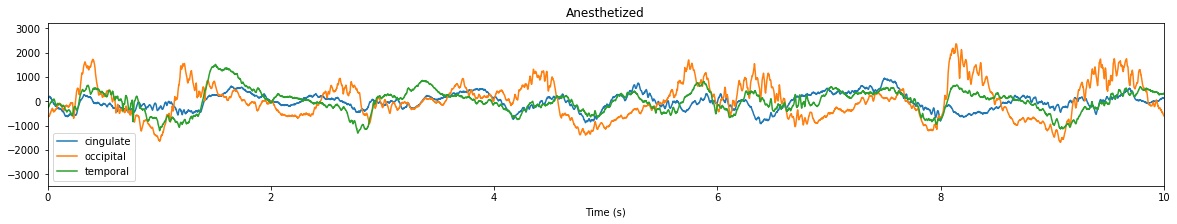

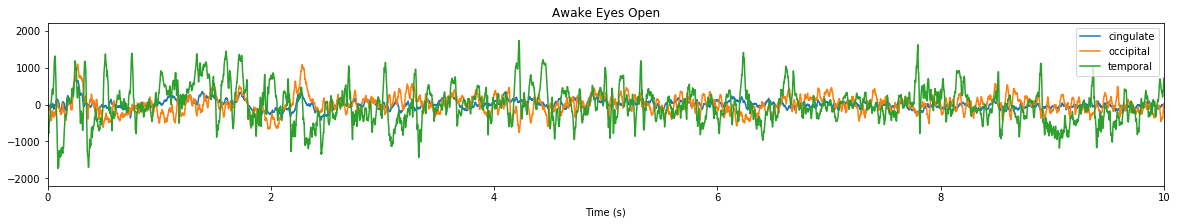

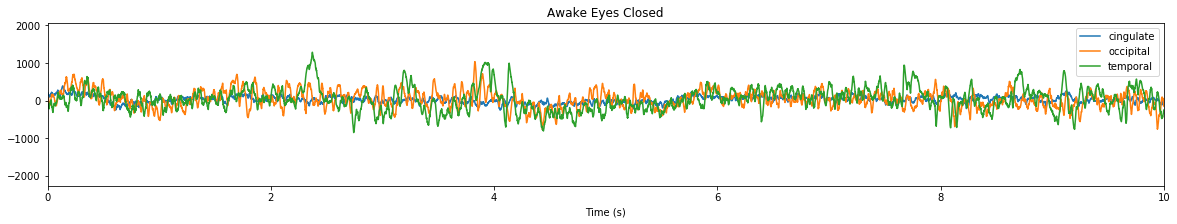

In [99]:
monkey.plot("Anesthetized", monkey.anes)
monkey.plot("Awake Eyes Open", monkey.eyes_open)
monkey.plot("Awake Eyes Closed", monkey.eyes_closed)

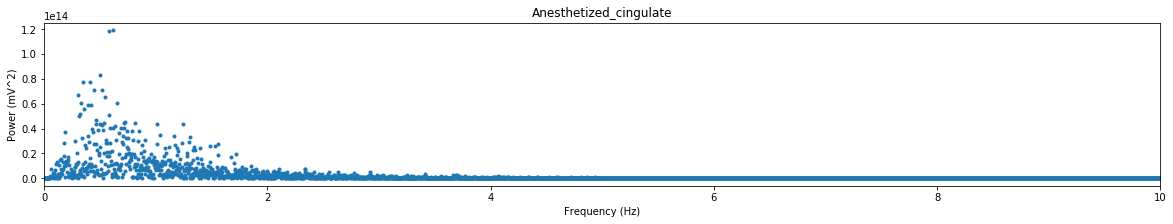

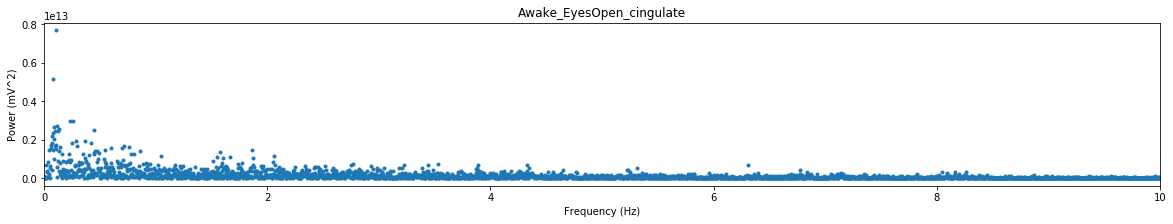

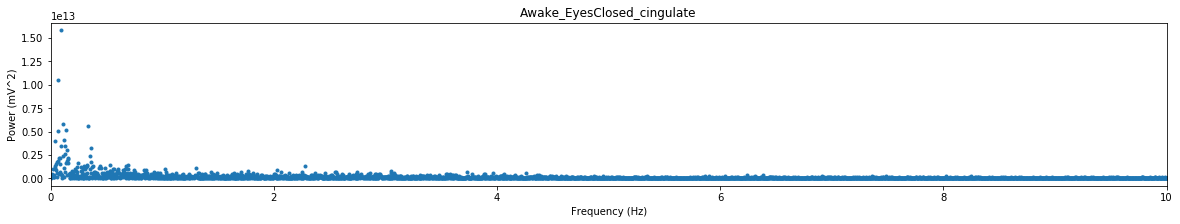

In [100]:
monkey.plot_power_spectrum("Anesthetized_cingulate", monkey.signal(monkey.anes, 'cingulate'), x_range = [0, 10])
monkey.plot_power_spectrum("Awake_EyesOpen_cingulate", monkey.signal(monkey.eyes_open, 'cingulate'), x_range = [0, 10])
monkey.plot_power_spectrum("Awake_EyesClosed_cingulate", monkey.signal(monkey.eyes_closed, 'cingulate'), x_range = [0, 10])

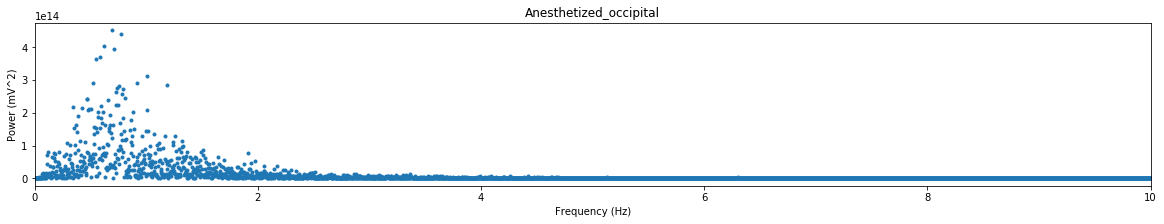

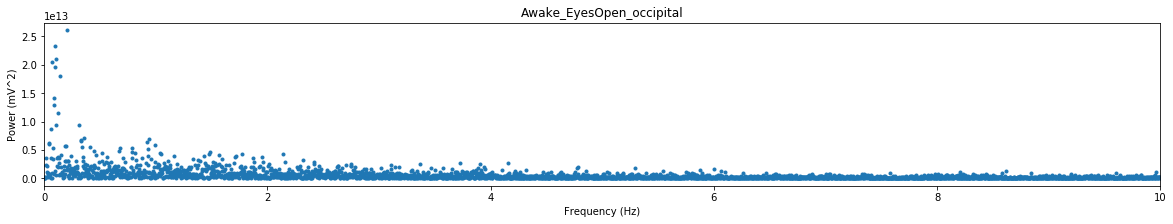

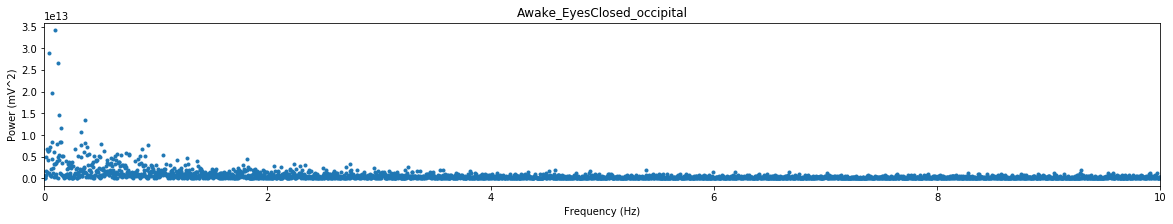

In [101]:
monkey.plot_power_spectrum("Anesthetized_occipital", monkey.signal(monkey.anes, 'occipital'), x_range = [0, 10])
monkey.plot_power_spectrum("Awake_EyesOpen_occipital", monkey.signal(monkey.eyes_open, 'occipital'), x_range = [0, 10])
monkey.plot_power_spectrum("Awake_EyesClosed_occipital", monkey.signal(monkey.eyes_closed, 'occipital'), x_range = [0, 10])

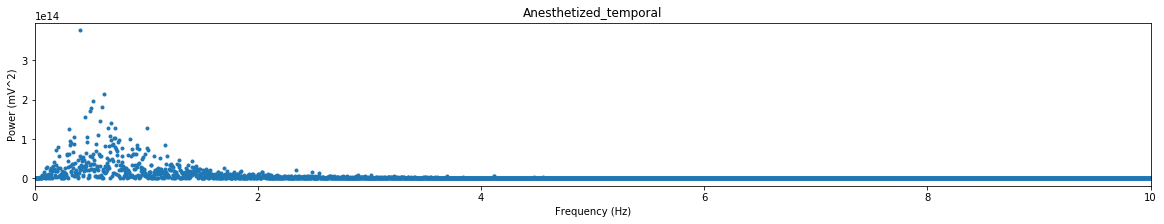

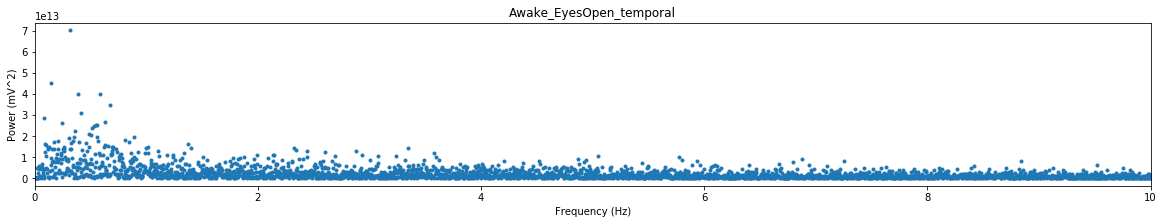

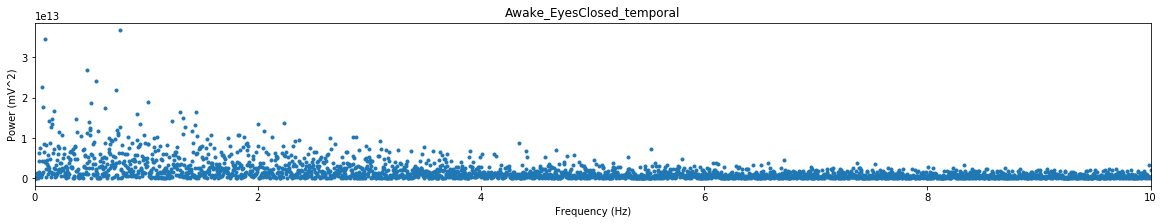

In [102]:
monkey.plot_power_spectrum("Anesthetized_temporal", monkey.signal(monkey.anes, 'temporal'), x_range = [0, 10])
monkey.plot_power_spectrum("Awake_EyesOpen_temporal", monkey.signal(monkey.eyes_open, 'temporal'), x_range = [0, 10])
monkey.plot_power_spectrum("Awake_EyesClosed_temporal", monkey.signal(monkey.eyes_closed, 'temporal'), x_range = [0, 10])

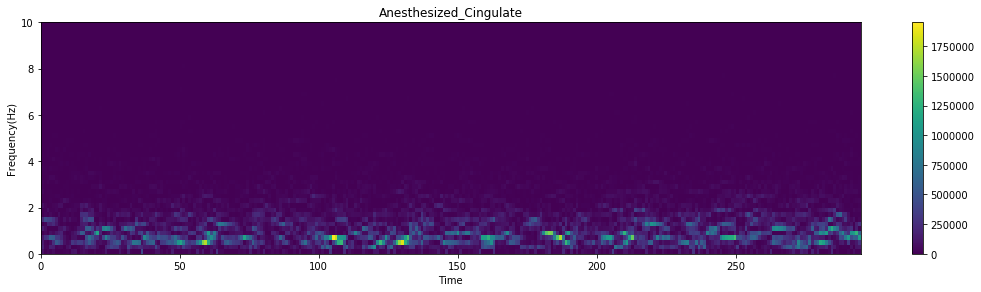

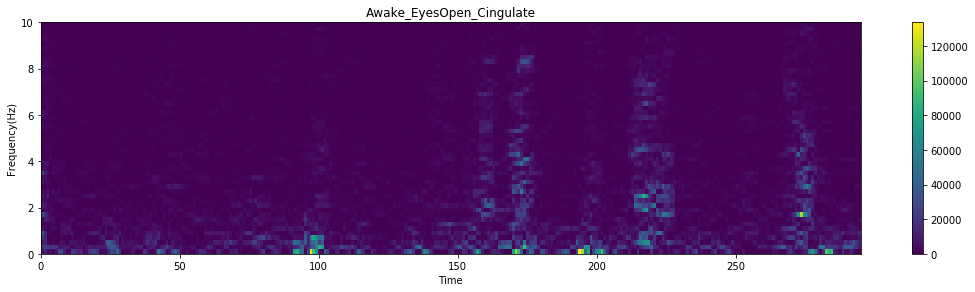

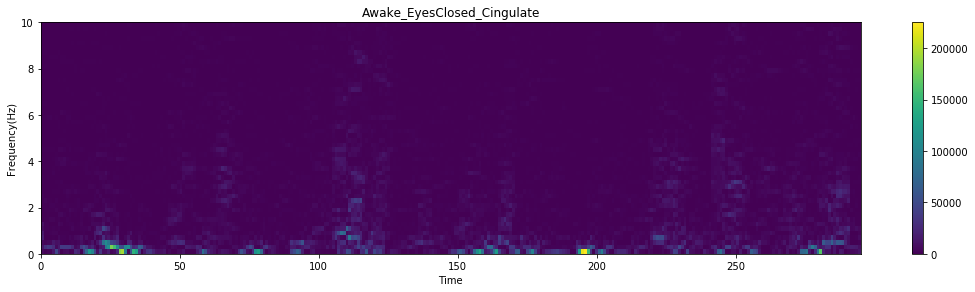

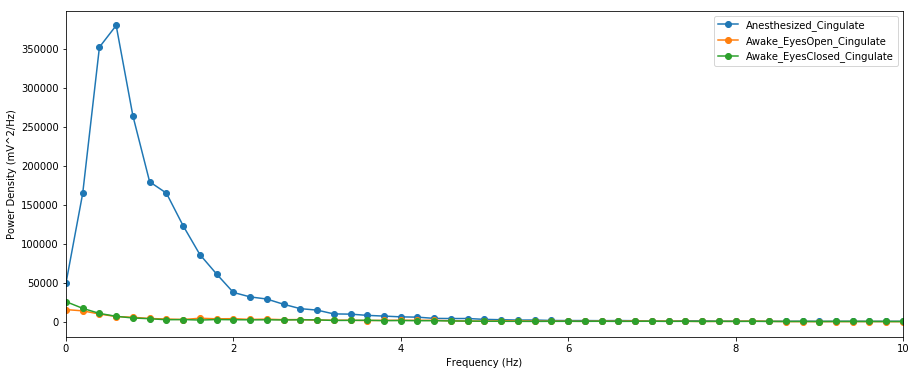

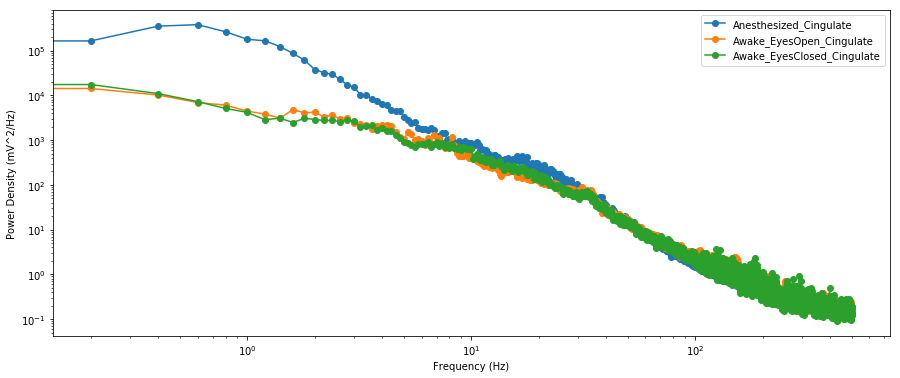

In [103]:
stft_anes = monkey.my_stft(monkey.signal(monkey.anes, 'cingulate'), monkey.fs, len_win=5, len_overlap=4)
stft_eo = monkey.my_stft(monkey.signal(monkey.eyes_open, 'cingulate'), monkey.fs, len_win=5, len_overlap=4)
stft_ec = monkey.my_stft(monkey.signal(monkey.eyes_closed, 'cingulate'), monkey.fs, len_win=5, len_overlap=4)

monkey.plot_spectrogram("Anesthesized_Cingulate", stft_anes, freq_range=[0,10])
monkey.plot_spectrogram("Awake_EyesOpen_Cingulate", stft_eo, freq_range=[0,10])
monkey.plot_spectrogram("Awake_EyesClosed_Cingulate", stft_ec, freq_range=[0,10])

monkey.plot_PSD_all(list([stft_anes, stft_eo, stft_ec]), 
                    labels = ["Anesthesized_Cingulate", "Awake_EyesOpen_Cingulate", "Awake_EyesClosed_Cingulate"], 
                    x_range = [0,10])
monkey.plot_PSD_all(list([stft_anes, stft_eo, stft_ec]), 
                    labels = ["Anesthesized_Cingulate", "Awake_EyesOpen_Cingulate", "Awake_EyesClosed_Cingulate"], 
                    x_range = None, loglog=True)

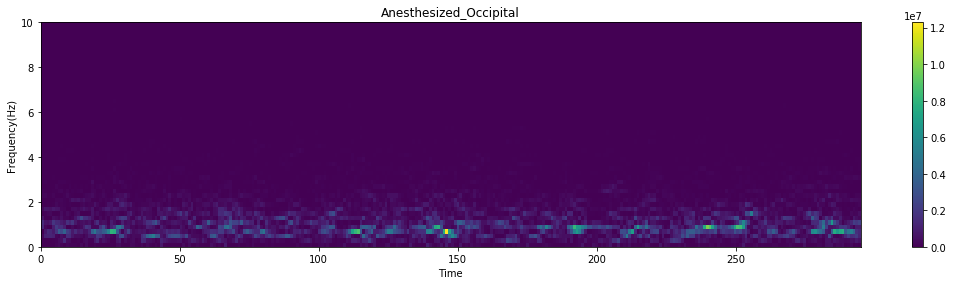

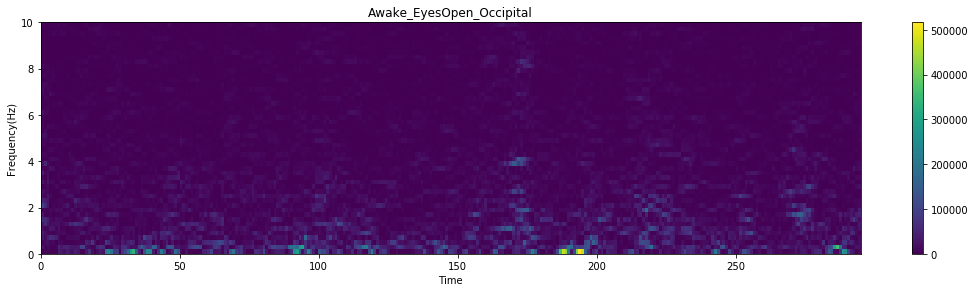

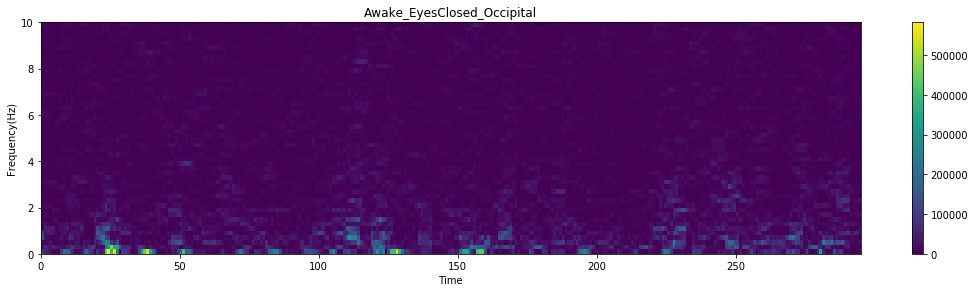

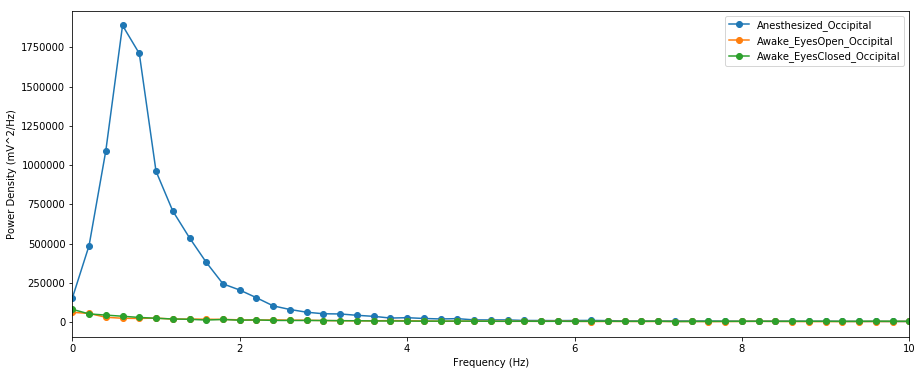

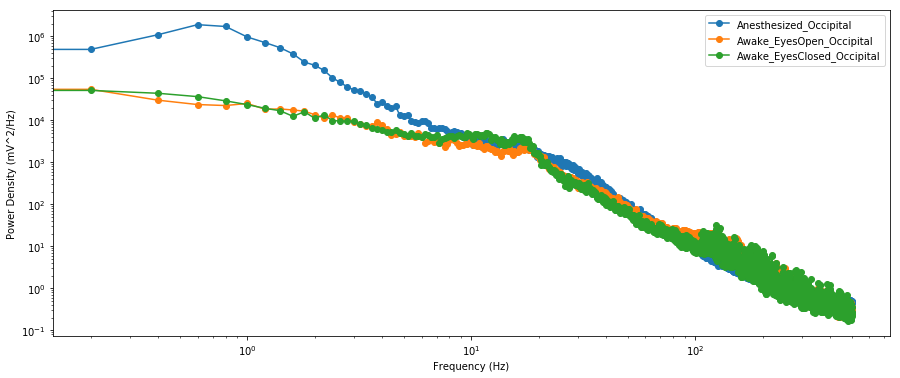

In [104]:
stft_anes = monkey.my_stft(monkey.signal(monkey.anes, 'occipital'), monkey.fs, len_win=5, len_overlap=4)
stft_eo = monkey.my_stft(monkey.signal(monkey.eyes_open, 'occipital'), monkey.fs, len_win=5, len_overlap=4)
stft_ec = monkey.my_stft(monkey.signal(monkey.eyes_closed, 'occipital'), monkey.fs, len_win=5, len_overlap=4)

monkey.plot_spectrogram("Anesthesized_Occipital", stft_anes, freq_range=[0,10])
monkey.plot_spectrogram("Awake_EyesOpen_Occipital", stft_eo, freq_range=[0,10])
monkey.plot_spectrogram("Awake_EyesClosed_Occipital", stft_ec, freq_range=[0,10])

monkey.plot_PSD_all(list([stft_anes, stft_eo, stft_ec]), 
                    labels = ["Anesthesized_Occipital", "Awake_EyesOpen_Occipital", "Awake_EyesClosed_Occipital"], 
                    x_range = [0,10])
monkey.plot_PSD_all(list([stft_anes, stft_eo, stft_ec]), 
                    labels = ["Anesthesized_Occipital", "Awake_EyesOpen_Occipital", "Awake_EyesClosed_Occipital"], 
                    x_range = None, loglog=True)

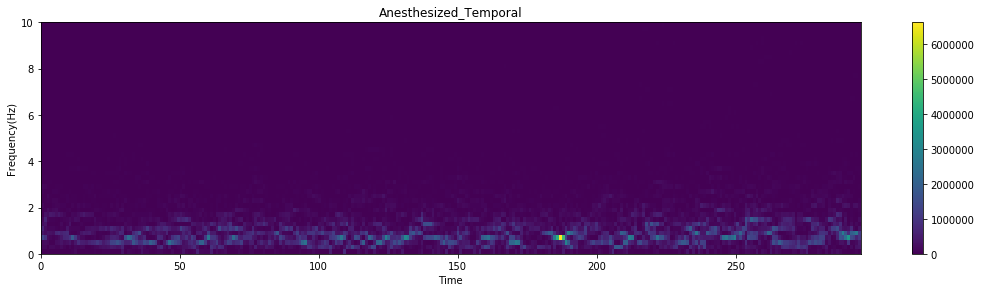

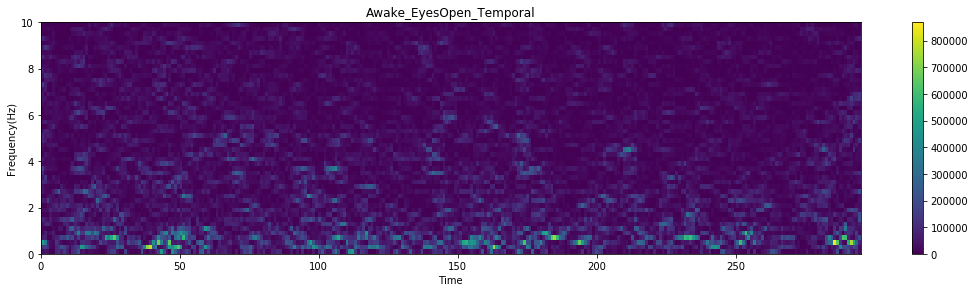

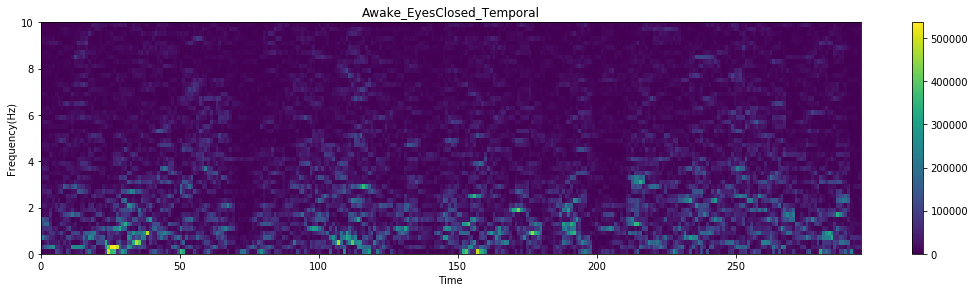

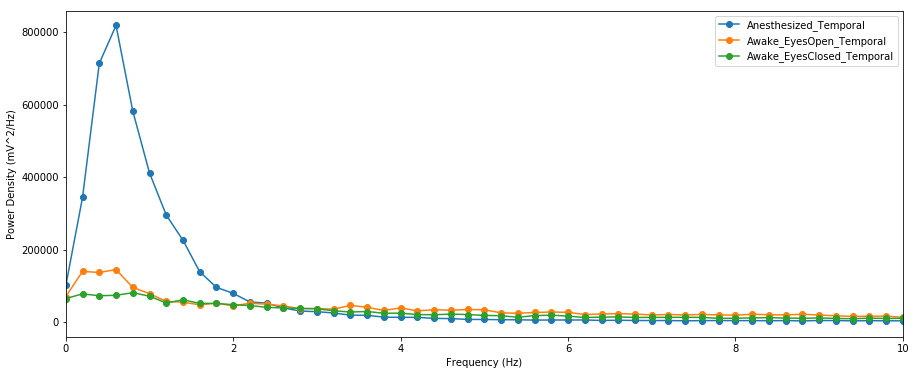

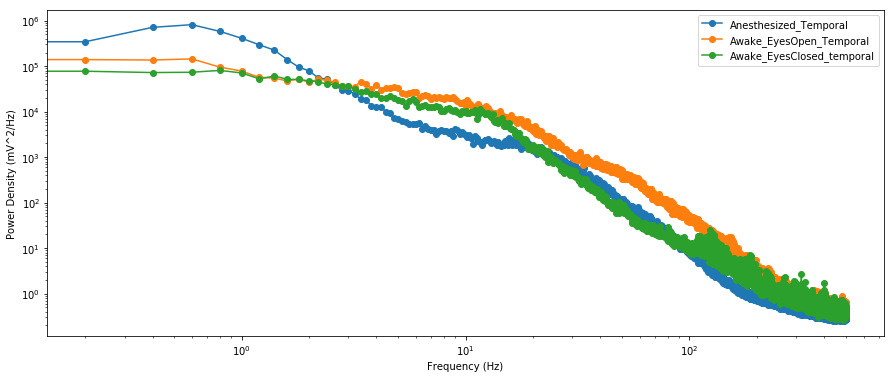

In [105]:
stft_anes = monkey.my_stft(monkey.signal(monkey.anes, 'temporal'), monkey.fs, len_win=5, len_overlap=4)
stft_eo = monkey.my_stft(monkey.signal(monkey.eyes_open, 'temporal'), monkey.fs, len_win=5, len_overlap=4)
stft_ec = monkey.my_stft(monkey.signal(monkey.eyes_closed, 'temporal'), monkey.fs, len_win=5, len_overlap=4)

monkey.plot_spectrogram("Anesthesized_Temporal", stft_anes, freq_range=[0,10])
monkey.plot_spectrogram("Awake_EyesOpen_Temporal", stft_eo, freq_range=[0,10])
monkey.plot_spectrogram("Awake_EyesClosed_Temporal", stft_ec, freq_range=[0,10])

monkey.plot_PSD_all(list([stft_anes, stft_eo, stft_ec]), 
                    labels = ["Anesthesized_Temporal", "Awake_EyesOpen_Temporal", "Awake_EyesClosed_Temporal"], 
                    x_range = [0,10])
monkey.plot_PSD_all(list([stft_anes, stft_eo, stft_ec]), 
                    labels = ["Anesthesized_Temporal", "Awake_EyesOpen_Temporal", "Awake_EyesClosed_temporal"], 
                    x_range = None, loglog=True)

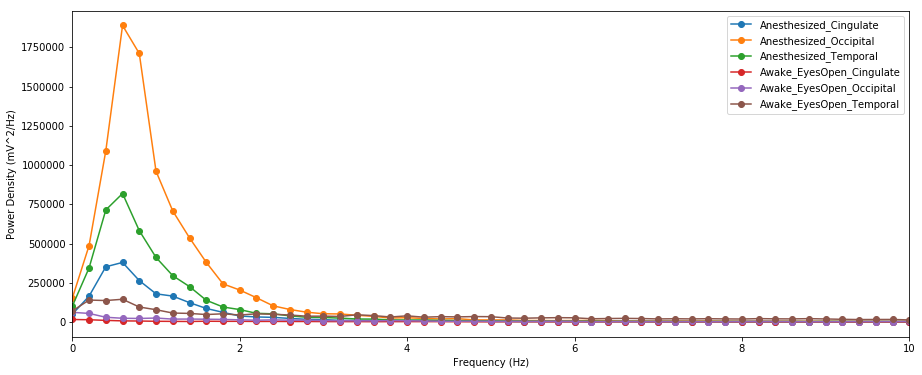

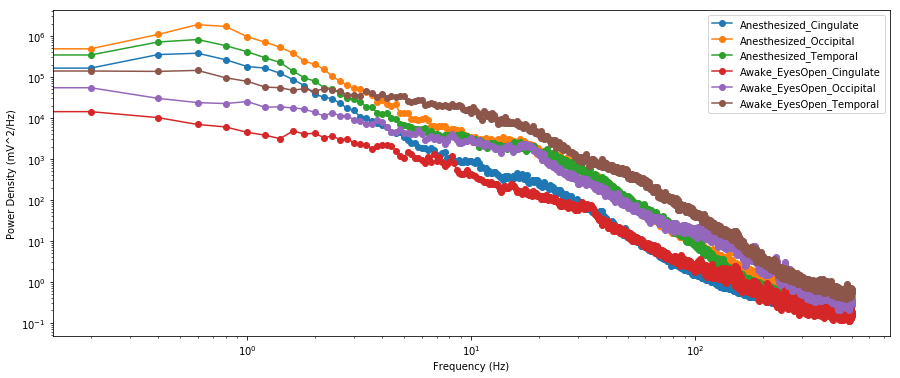

In [106]:
stft_anes_cing = monkey.my_stft(monkey.signal(monkey.anes, 'cingulate'), monkey.fs, len_win=5, len_overlap=4)
stft_anes_occi = monkey.my_stft(monkey.signal(monkey.anes, 'occipital'), monkey.fs, len_win=5, len_overlap=4)
stft_anes_temp = monkey.my_stft(monkey.signal(monkey.anes, 'temporal'), monkey.fs, len_win=5, len_overlap=4)

stft_eo_cing = monkey.my_stft(monkey.signal(monkey.eyes_open, 'cingulate'), monkey.fs, len_win=5, len_overlap=4)
stft_eo_occi = monkey.my_stft(monkey.signal(monkey.eyes_open, 'occipital'), monkey.fs, len_win=5, len_overlap=4)
stft_eo_temp = monkey.my_stft(monkey.signal(monkey.eyes_open, 'temporal'), monkey.fs, len_win=5, len_overlap=4)



monkey.plot_PSD_all(list([stft_anes_cing, stft_anes_occi, stft_anes_temp, stft_eo_cing, stft_eo_occi, stft_eo_temp]), 
                    labels = ["Anesthesized_Cingulate", "Anesthesized_Occipital", "Anesthesized_Temporal", 
                              "Awake_EyesOpen_Cingulate", "Awake_EyesOpen_Occipital", "Awake_EyesOpen_Temporal"], 
                    x_range = [0,10])

monkey.plot_PSD_all(list([stft_anes_cing, stft_anes_occi, stft_anes_temp, stft_eo_cing, stft_eo_occi, stft_eo_temp]), 
                    labels = ["Anesthesized_Cingulate", "Anesthesized_Occipital", "Anesthesized_Temporal", 
                              "Awake_EyesOpen_Cingulate", "Awake_EyesOpen_Occipital", "Awake_EyesOpen_Temporal"], 
                    loglog = True)


# Delta

# Gamma